In [122]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [123]:
@jax.jit

def dmglik(y_group,mu,sigma,alpha):
    return(jnp.log(1/alpha)+jax.scipy.stats.norm.logpdf(y_group/alpha,loc = mu,scale = sigma))


In [124]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.4
c = 0.65
s = 10

N_marginal = 139





In [125]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[1], shape=(N, )) + mu
y = y[y>0]

y_obs = y*alpha

y_group2 = jnp.shape(y_obs[y_obs < l ])[0]
y_group3 = y_obs[y_obs > l ]



In [126]:
y_group3 

Array([37.29614 , 33.350246, 34.634773, 34.151253, 36.929195, 37.160515,
       40.702137, 35.662045, 33.93952 , 33.512455, 35.169777, 33.990337,
       33.034397, 33.30171 , 33.46543 ], dtype=float32)

In [127]:

@jax.jit
def negdmglik_jax(alpha):
    lik2 = y_group2*jnp.log(
        jax.scipy.stats.norm.cdf(l/alpha, loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(1e-6/alpha, loc=mu, scale=sigma)
        )
    lik3 = jnp.sum(jax.vmap(lambda y_obs: dmglik(y_obs,mu,sigma,alpha))(y_group3))

    return(-lik2-lik3)

negdmglik_jax(alpha)

Array(92.644325, dtype=float32)

In [128]:


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(alpha)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
alpha

(Array(0.4028125, dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(92.612045, dtype=float32), success=True, status=0, iter_num=9, hess_inv=None))

0.4

In [129]:
 negdmglik_jax(.1)
 negdmglik_jax(.2)
 negdmglik_jax(.05)


Array(1939.5677, dtype=float32)

Array(375.03214, dtype=float32)

Array(8928.691, dtype=float32)

In [130]:
jnp.sum(jax.vmap(lambda y_obs: dmglik(y_obs,mu,sigma,alpha))(y_group3))

Array(-77.52829, dtype=float32)

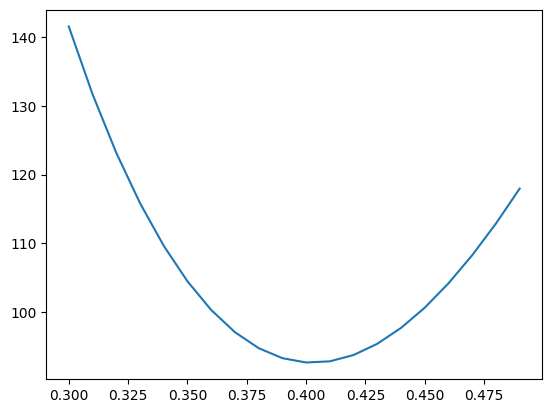

In [131]:
alpha_seq = jnp.arange(alpha -0.1, alpha+0.1,0.01)
lik_seq = jax.vmap(negdmglik_jax)(alpha_seq )
plt.plot(alpha_seq,lik_seq)